In [7]:
%matplotlib nbagg 
import numpy as np
from scipy import signal, fftpack
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Determinación del tiempo de retardo entre dos señales mediante técnicas de análisis aleatorio

### Organizació de esta notebook:

+ Creación de las señales simuladas con retardo

 1) Análisis en el dominio frecuencial
 
   - Estimación de los espectros para cada señal (PSD)
   - Estimación del espectro cruzado entre las señales (CPSD)
   - Análisis del módulo y la fase del espectro cruzado
   - Estimación del tiempo de retardo a partir de la fase de la CPSD
 
 2) Análisis en el dominio temporal

   Se estima el tiempo de retardo mediante tres métodos distintos
   
   - Correlación cruzada (CC) directa
   - CC a partir de la CPSD obtenida con el estimador del periodograma
   - CC a partir de la CPSD obtenida con el estimador de Welch
   
   
--------------------------------------------------
   

### Descripción del problema:


El problema se modela asumiendo que es posible medir las señales x(t) e y(t) y que se desea averigual el tiempo de retardo $\tau$ que existen entre llas:

\begin{align}
x(t) &= s(t) + n_1(t) \\
y(t) &= s(t-\tau) + n_2(t)
\end{align}

donde:

- s(t) es el término de la señal que posee la información de interés
- n$_1$(t) y n$_2$(t) es el término de ruido aleatorio presente en las señales 1 y 2. Se asumirá que estos ruidos no correlacionado entre sí ni tampoco lo están con la señal s(t)

Siendo más estrícto, se debería decir que todas las señales deben ser continuas para todo tiempo y deben representar procesos estocásticos estacionarios. Al formalizar la teoría, también se debe pedir que sean procesos ergódicos. Por conveniencia, se trabaja con procesos de media nula:  E[x(t)] = E[y(t)] = 0 

### Parámetros de entrada:

In [8]:
# Frecuencia de muestreo [Hz]
fs = 1e3
# Cantidad de datos de cada señal
N = 1e4
# Amplitud de la señal
s_amp = 2
# Amplitud del ruido en 1
n1_amp = 1
# Amplitud del ruido en 2
n2_amp = 1
# Tiempo de retardo simulado [s]
tau = 0.02

### Construcción de las señales simuladas

En esta sección se simulan dos señales con un tiempo de retardo entre ellas, y se le agrega ruido no correlacionado.

In [9]:
# Vector temporal
tiempo = np.arange(0,N) / fs   # ver que dt = 1/fs
# Genero números aleatorios con distribución normal
# Con estos valores me contruiré la s(t) y s(t-tau)
random_signal = s_amp * np.random.normal(size=2*tiempo.size)

if True:
    b, a = signal.butter(4, 0.2, 'low')
    random_signal = signal.lfilter(b, a, random_signal)

# Cantidad e puntos que necesito desplazar la señal
delay = int(tau * fs)
print('Tiempo de retardo: {} s'.format(delay/fs))

# Construyo la señal s(t) 
signal_1 = random_signal[delay:delay+tiempo.size]
# Construyo la señal s(t-tau) retrasada respecto a la anterior
signal_2 = random_signal[0:tiempo.size]

noise_1 = n1_amp * np.random.normal(size=tiempo.shape) 
noise_2 = n2_amp * np.random.normal(size=tiempo.shape) 

x = signal_1 + noise_1
y = signal_2 + noise_2

Tiempo de retardo: 0.02 s


### Gráfico de las señales temporales

<IPython.core.display.Javascript object>


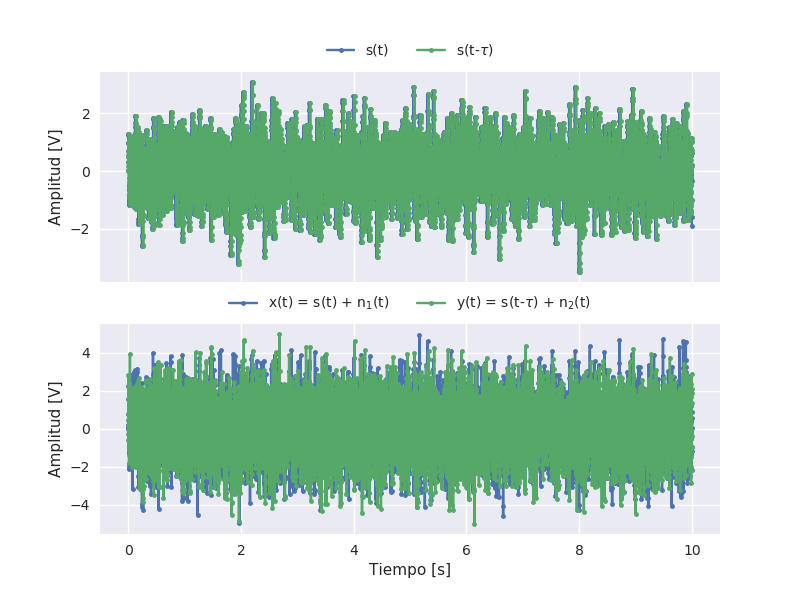

In [10]:
fig1, ax = plt.subplots(2,1, figsize=(8,6), sharex=True)

ax[0].plot(tiempo, signal_1, '.-', label=r's(t)')
ax[0].plot(tiempo, signal_2, '.-', label=r's(t-$\tau$)')
ax[0].set_ylabel('Amplitud [V]')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)

ax[1].plot(tiempo, x, '.-', label=r'x(t) = s(t) + n$_1$(t)')
ax[1].plot(tiempo, y, '.-', label=r'y(t) = s(t-$\tau$) + n$_2$(t)')
ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Amplitud [V]')
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
##plt.show()

### Estimación de los espectros de cada señal:

Si se toma la transformada de Fourir de las expresiones para x(t) se obtiene:

\begin{align}
\mathcal{F}\{x(t)\} &= X(f) = S(f) + N_1(f) \\
\mathcal{F}\{y(t)\} &= Y(f) = S(f)e^{j 2\pi\tau f} + N_2(f)
\end{align}

<IPython.core.display.Javascript object>


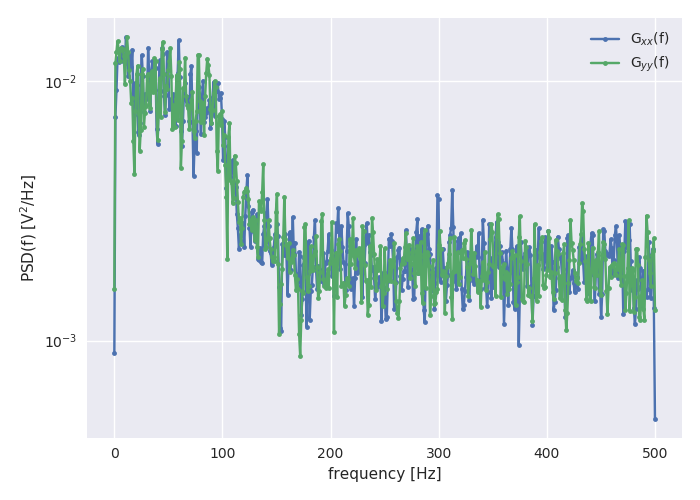

In [11]:
fig2, ax = plt.subplots(1,1, figsize=(7,5))

f, Gxx= signal.welch(x, fs, nperseg=1024)
f, Gyy = signal.welch(y, fs, nperseg=1024)

ax.semilogy(f, Gxx, '.-', label='G$_{xx}$(f)')
ax.semilogy(f, Gyy, '.-', label='G$_{yy}$(f)')
#ax.set_ylim([0.5e-4, 1e-1])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD(f) [V$^2$/Hz]')
ax.legend()
plt.tight_layout()
plt.show()


### Estimación del espectro cruzado y coherencia entre las señales:

<IPython.core.display.Javascript object>


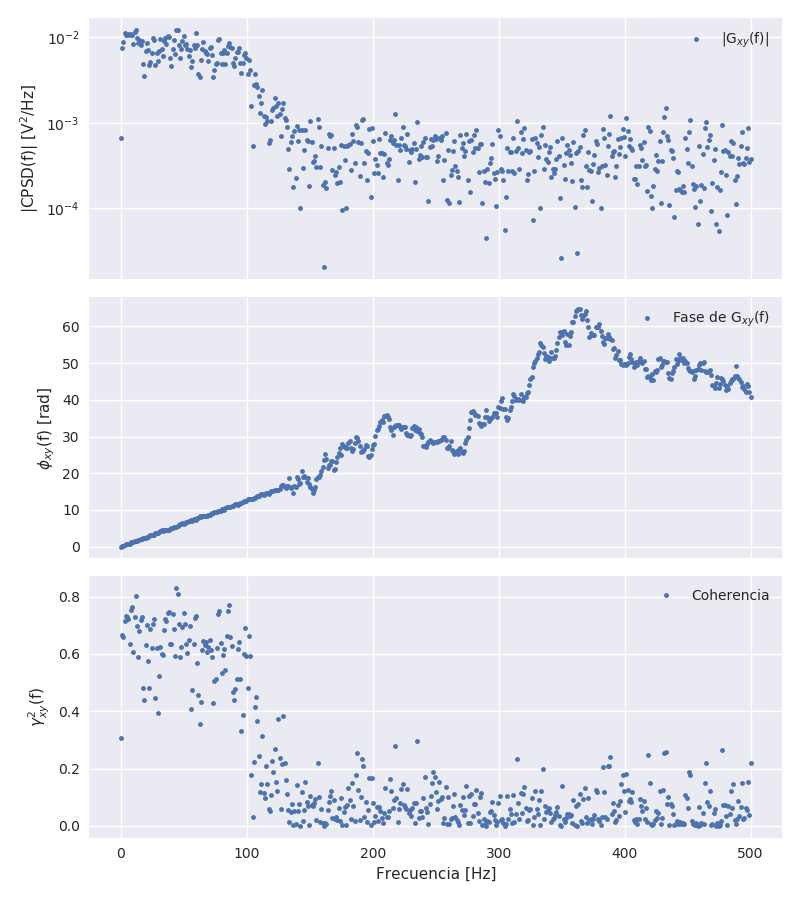

In [12]:
# Se calcula la CPSD 
f, Gxy = signal.csd(x, y, fs, nperseg=1024)

# Se obtiene el módulo
abs_Gxy = np.abs(Gxy)
# Se obtiene la fase
pha_Gxy = -np.angle(Gxy)
pha_Gxy = np.unwrap(pha_Gxy)

# Se obtiene la coherencia
f, Cxy = signal.coherence(x, y, fs, nperseg=1024)


fig3, ax = plt.subplots(3,1, figsize=(8,9), sharex=True)
ax[0].semilogy(f, abs_Gxy, '.', label='|G$_{xy}$(f)|')
ax[0].set_ylabel(r'|CPSD(f)| [V$^2$/Hz]')
ax[0].legend()

ax[1].plot(f, pha_Gxy, '.', label='Fase de G$_{xy}$(f)')
ax[1].set_ylabel(r'$\phi_{xy}$(f) [rad]')
ax[1].legend()

ax[2].plot(f, Cxy, '.', label='Coherencia')
ax[2].set_ylabel(r'$\gamma_{xy}^2$(f)')
ax[2].set_xlabel('Frecuencia [Hz]')
ax[2].legend()

fig3.tight_layout()


### Estimación del tiempo de tránsito:

<IPython.core.display.Javascript object>


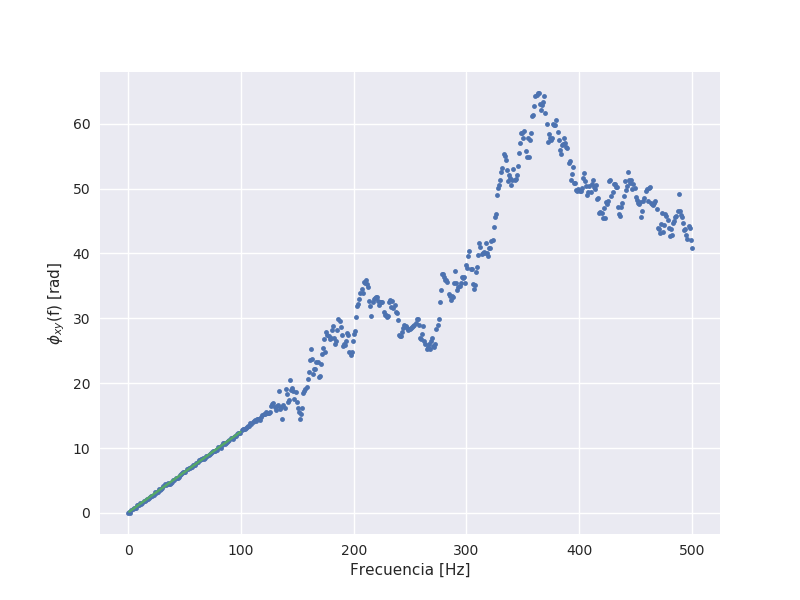

TIempo de tránsito estimado: (1.981e-02 +/- 7.158e-05) s


In [13]:
f_min = 0
f_max = 100

indx_fit = (f_min < f) & (f <= f_max)
z, cov = np.polyfit(f[indx_fit], pha_Gxy[indx_fit], 1, cov=True)
p = np.poly1d(z)

fig4, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(f, pha_Gxy, '.', label='Medición')
ax.plot(f[indx_fit], p(f[indx_fit]), label='Ajuste lineal')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel(r'$\phi_{xy}$(f) [rad]')

m = z[0]
sigma_m = np.sqrt(cov[0,0])
tau = m/2/np.pi
sigma_tau = sigma_m/2/np.pi

plt.show()
print('TIempo de tránsito estimado: ({:.3e} +/- {:.3e}) s'.format(tau, sigma_tau))

# Tiempo de tránsito en el dominio temporal

## 1) Utilizando la correlación cruzada de forma directa

<IPython.core.display.Javascript object>


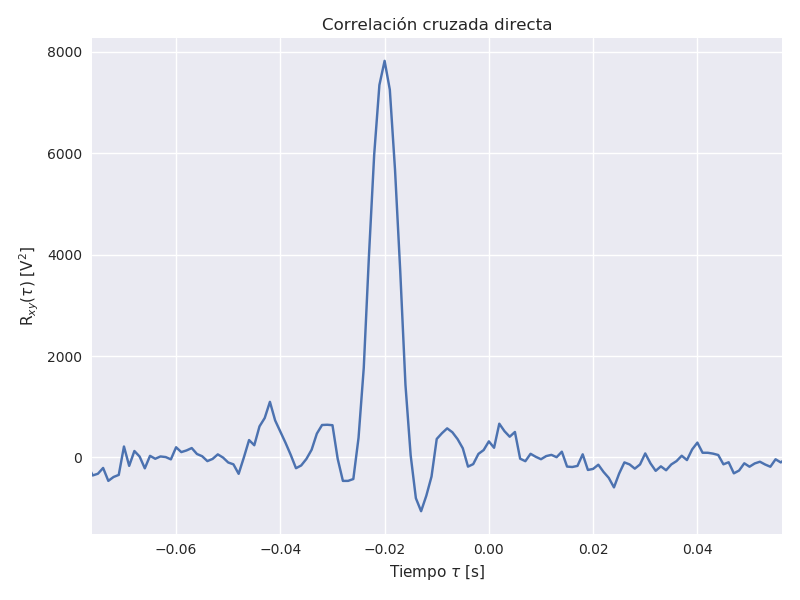

In [16]:
# Se estima la correlación cruzada
Rxy_dir = signal.correlate(x,y)
# Vector de tiempos
lag = np.arange(-x.size+1, x.size) / fs

fig5, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(lag, Rxy_dir)
ax.set_xlabel(r'Tiempo $\tau$ [s]')
ax.set_ylabel(r'R$_{xy}$($\tau$) [V$^2$]')
ax.set_title('Correlación cruzada directa')
fig5.tight_layout()
plt.show()

### Utilizando la transformada inversa de la CPSD estimada con el periodograma

<IPython.core.display.Javascript object>


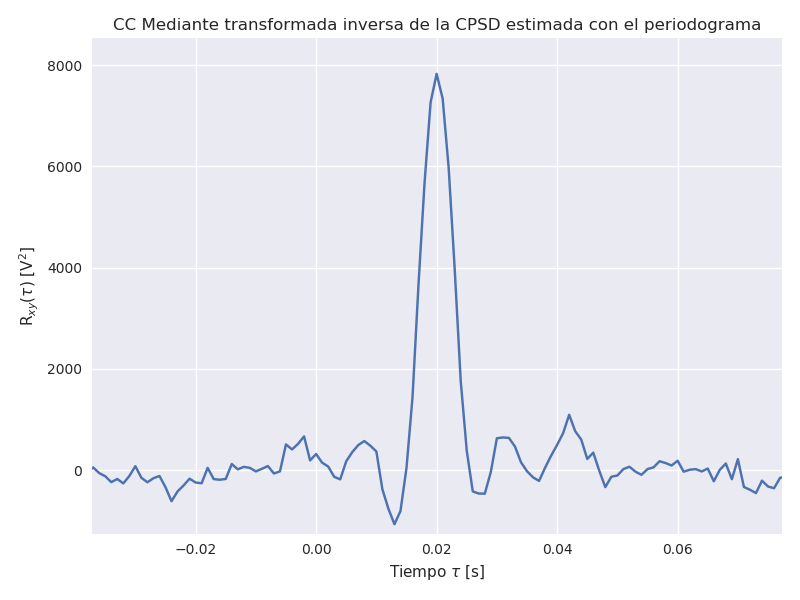

In [24]:
# Esimación de la Transformada de fourier con todos los datos
X = fftpack.fft(x)
Y = fftpack.fft(y)

# Estimo el espectro cruzado mediante el estimador del periodograma e invierto Fourier
Rxy_periodograma = fftpack.ifft(np.conj(X)*Y)
# Ordeno los datos
Rxy_periodograma = fftpack.fftshift(Rxy_periodograma)
# Vector de tiempos
lag = np.arange(-N/2,N/2)/fs

fig6, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(lag, Rxy_periodograma.real)
ax.set_xlabel(r'Tiempo $\tau$ [s]')
ax.set_ylabel(r'R$_{xy}$($\tau$) [V$^2$]')
ax.set_title('CC Mediante transformada inversa de la CPSD estimada con el periodograma')
fig6.tight_layout()
plt.show()

### Como la transformada inversa de la CPSD estimada por Welch

<IPython.core.display.Javascript object>


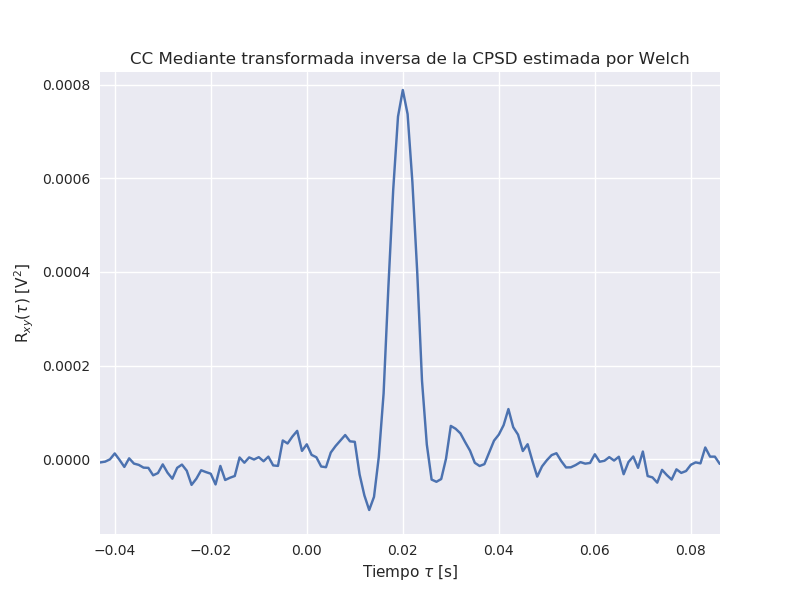

In [25]:
# Se estima la CPSD con el estimador de Welch
f, Gxy = signal.csd(x, y, fs, nperseg=1024, return_onesided=False)
# Se estima la CC 
Rxy_welch = fftpack.ifft(Gxy)
# Se acomodan los datos
Rxy_welch = fftpack.fftshift(Rxy_welch)
# Vector de tiempos
lag = np.arange(-Gxy.size/2, Gxy.size/2)/fs

fig7, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(lag, Rxy_welch.real)
ax.set_xlabel(r'Tiempo $\tau$ [s]')
ax.set_ylabel(r'R$_{xy}$($\tau$) [V$^2$]')
ax.set_title('CC Mediante transformada inversa de la CPSD estimada por Welch')
fig6.tight_layout()
plt.show()

### Referencias

#### 1) Funciones más relevantes utilizadas

https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.welch.html

https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.csd.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html